<b><p style="text-align: center;">Описание проекта</p></b>

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.  <br> 

<b><p style="text-align: center;">Цель проекта</p></b>
Предсказать вероятность покупки в течение 90 дней


<b><p style="text-align: center;">Краткий план</p></b>
- Изучить данные </b>
- Разработать полезные признаки </b>
- Создать модель для классификации пользователей </b>
- Улучшить модель и максимизировать метрику roc_auc </b>
- Выполнить тестирование </b>

<b><p style="text-align: center;">Данные</p></b>
Датасет "история покупок" (apparel-purchases):</b>
- `client_id` идентификатор пользователя</b>
- `quantity` количество товаров в заказе</b>
- `price` цена товара</b>
- `date` дата покупки</b>
- `message_id` идентификатор сообщения из рассылки</b>

Датасет "история рекламных рассылок" (apparel-messages):</b>
- `bulk_campaign_id` идентификатор рекламной кампании</b>
- `client_id` идентификатор пользователя</b>
- `message_id` идентификатор сообщений</b>
- `event` тип действия</b>
- `channel` канал рассылки</b>
- `date` дата рассылки</b>
- `created_at` точное время создания сообщения</b>

Датасет "совершит ли клиент покупку в течение следующих 90 дней" () (apparel-target_binary):</b>
- `client_id` идентификатор пользователя</b>
- `target` целевой признак</b>

Датасет "Агрегация по дням с учетом событий и каналов рассылки" (full_campaign_daily_event_channel):</b>
- `date` дата </b>
- `bulk_campaign_id` идентификатор рассылки</b>
- `count_event_channel` общее количество каждого события по каналам</b>
- `nunique_event_channel` количество уникальных client_id по событиям и каналам</b>

Датасет "Агрегация общей базы рассылок по дням и типам событий" (full_campaign_daily_event):</b>
- `date` дата</b>
- `bulk_campaign_id` идентификатор рассылки</b>
- `count_event` общее количество каждого события event</b>
- `nunique_event` количество уникальных client_id в каждом событии</b>

*(Общая база рассылок огромна, поэтому статистика агрегированна по дням
 по рассылкам, нельзя суммировать по колонкам nunique, потому что это уникальные клиенты в пределах дня, у нас нет данных, повторяются ли они в другие дни)*</b>

<b><p style="text-align: center;">Cтек</p></b>
- python
- pandas
- sklearn

<b><p style="text-align: center;">Задачи</p></b>
1. Загрузка данных</b>
2. Предобработка данных<br>
3. Исследовательский анализ данных <br>
4. Обучение модели<br>
5. **Итоговые выводы**

# Импорт библиотек

In [1]:
#устанваливаем phik
!pip install phik
# устанавливаем shap
!pip install shap 

In [2]:
# загрузка стандартных библиотек
import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

# импортируем коэффициент phik
from phik import report
from phik.report import plot_correlation_matrix

# импортируем  метод SHAP
import shap

# для модели МО
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# метрика
from sklearn.metrics import (roc_auc_score,
                        roc_curve,
                        confusion_matrix,
                        classification_report,
                        recall_score, 
                        precision_score, 
                        accuracy_score,
                        precision_recall_curve, 
                        average_precision_score 
)

# импортируем функции для графика ROC-кривой
from sklearn.metrics import RocCurveDisplay

# Загрузка датасетов

In [3]:
# указание пути к моей тетрадке для python, чтобы мог использовать модули
import sys 
sys.path.append(r'c:\Users\msmk8\REPO\users_ready_to_buy')

In [4]:
# добавляем пути как переменные
from utils.params import ROOT_PATH, DATA_PATH

In [5]:
hist_purch = pd.read_csv(DATA_PATH /'apparel-purchases.csv')
hist_purch.head(3)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843


In [6]:
hist_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


- пропуски в `hist_purch` отсутствуют
- признак date - имеет тип object, заменим на тип datetime 
- признак category_ids - имеет тип object, оставим так как это категрии, а не числа

In [7]:
hist_purch['date'] = pd.to_datetime(hist_purch['date'], errors='coerce')
# проверка
print(hist_purch['date'].dtype)

datetime64[ns]


In [8]:
hist_adds_message = pd.read_csv(DATA_PATH /'apparel-messages.csv')
hist_adds_message.head(3)

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49


In [9]:
hist_adds_message.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Non-Null Count     Dtype 
---  ------            --------------     ----- 
 0   bulk_campaign_id  12739798 non-null  int64 
 1   client_id         12739798 non-null  int64 
 2   message_id        12739798 non-null  object
 3   event             12739798 non-null  object
 4   channel           12739798 non-null  object
 5   date              12739798 non-null  object
 6   created_at        12739798 non-null  object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


- пропуски в `hist_adds_message` отсутствуют
- признак 'date' и 'created_at' - имеет тип object, заменим на тип datetime 
- остальные признаки по смыслу категориальные, оставим тип object

In [10]:
hist_adds_message['date'] = pd.to_datetime(hist_adds_message['date'], errors='coerce')
hist_adds_message['created_at'] = pd.to_datetime(hist_adds_message['created_at'].str.replace(' ', 'T'), format='%Y-%m-%dT%H:%M:%S')
# проверка
print(hist_adds_message['date'].dtype)
print(hist_adds_message['created_at'].dtype)

datetime64[ns]
datetime64[ns]


In [11]:
client_target = pd.read_csv(DATA_PATH /'apparel-target_binary.csv')
client_target.head(3)

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0


In [12]:
client_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


- пропуски в `client_target` отсутствуют

In [13]:
agg_day_type_event_channel = pd.read_csv(DATA_PATH /'full_campaign_daily_event_channel.csv')
agg_day_type_event_channel.head(3)

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
agg_day_type_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null  int64 
 12  nunique_click_mo

- пропуски в `agg_day_type_event_channel` отсутствуют
- признак 'date' - имеет тип object, заменим на тип datetime 

In [15]:
agg_day_type_event_channel['date'] = pd.to_datetime(hist_adds_message['date'], errors='coerce')
# проверка
print(agg_day_type_event_channel['date'].dtype)

datetime64[ns]


In [16]:
agg_day_type_event = pd.read_csv(DATA_PATH /'full_campaign_daily_event.csv')
agg_day_type_event.head(3)

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0


In [17]:
agg_day_type_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nunique_purchase     131072 non-nu

- пропуски в `agg_day_type_event` отсутствуют
- признак 'date' - имеет тип object, заменим на тип datetime 

In [18]:
agg_day_type_event['date'] = pd.to_datetime(hist_adds_message['date'], errors='coerce')
# проверка
print(agg_day_type_event['date'].dtype)

datetime64[ns]


- **5 датасетов успешно подгружены**

## Предобработка данных

In [19]:
hist_purch.describe()

,client_id,quantity,price,date
count,2.022080e+05,202208.000000,202208.000000,202208
mean,1.515916e+18,1.006483,1193.301516,2023-03-17 02:49:35.739832064
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00
25%,1.515916e+18,1.000000,352.000000,2022-11-12 00:00:00
50%,1.515916e+18,1.000000,987.000000,2023-04-12 00:00:00
75%,1.515916e+18,1.000000,1699.000000,2023-07-03 00:00:00
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00
std,1.459458e+08,0.184384,1342.252664,NaN


In [20]:
print('Кол-во полных дубликатов', hist_purch.duplicated().sum())
total_miss =  hist_purch.duplicated().sum()
total_val = hist_purch.shape[0]
print('Процент полных дубликатов', ((total_miss/total_val)*100).round(1), '%')

Кол-во полных дубликатов 73020
Процент полных дубликатов 36.1 %


- количественные признаки датасета `hist_purch` не имеют не логичных значений исходя из минимальных, максимальных и средних значений
- **полные дубликаты не являются ошибкой, один и тот же клиент мог купить один и тот же товар, в одинаковом количестве с одной категории в одну и туже дату**

In [21]:
hist_adds_message.describe()

,bulk_campaign_id,client_id,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798
mean,1.160459e+04,1.515916e+18,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,2024-02-15 00:00:00,2024-02-15 23:58:40
std,3.259211e+03,1.329704e+08,NaN,NaN


In [22]:
print('Кол-во полных дубликатов', hist_adds_message.duplicated().sum())
total_miss =  hist_adds_message.duplicated().sum()
total_val = hist_adds_message.shape[0]
print('Процент полных дубликатов', ((total_miss/total_val)*100).round(1), '%')

Кол-во полных дубликатов 48610
Процент полных дубликатов 0.4 %


- датасет `hist_adds_message` в основном имеет категориальные признаки типа 'Object', по количественным признакам, в том числе по датам не согласованости не наблюдается
- - **полных дубликатов по датасету `hist_adds_message` 48610, что составляет 0,4% от всего объема датасета, когда есть признак created_at - точная дата и время, то наличие полных дубликатов становится подозрительным, так как строки совпали до секунды, удалим такие данные**

In [23]:
hist_adds_message = hist_adds_message.drop_duplicates()
# проверка
print('Кол-во полных дубликатов', hist_adds_message.duplicated().sum())

Кол-во полных дубликатов 0


In [24]:
client_target.describe()

,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [25]:
print('Кол-во полных дубликатов', client_target.duplicated().sum())
total_miss =  client_target.duplicated().sum()
total_val = client_target.shape[0]
print('Процент полных дубликатов', ((total_miss/total_val)*100).round(1), '%')

Кол-во полных дубликатов 0
Процент полных дубликатов 0.0 %


- по датасету `hist_adds_message` по описательной таблице (мин макс среднее) аномалий нет, дубликатов нет

In [26]:
agg_day_type_event_channel.describe()

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072,131072.000000,131072.000000,131072.000000,1.310720e+05,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,...,1.310720e+05,131072.000000,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,2022-05-22 11:31:07.675781120,8416.743378,41.582169,49.400803,4.237060e+02,3.347385e+03,0.357483,0.220444,24.474823,0.140518,...,4.189581e+03,18.535683,0.809799,4.186898e+03,3.332489,3.311653,0.932655,0.921326,0.000008,0.000008
min,2022-05-19 00:00:00,548.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-05-20 00:00:00,4116.000000,0.000000,0.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-05-23 00:00:00,7477.000000,0.000000,0.000000,5.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2022-05-25 00:00:00,13732.000000,1.000000,0.000000,2.300000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2022-05-27 00:00:00,15150.000000,59365.000000,128453.000000,2.597015e+06,5.076151e+06,1077.000000,431.000000,76284.000000,189.000000,...,7.094600e+06,287341.000000,63920.000000,7.094600e+06,21831.000000,21389.000000,5160.000000,5043.000000,1.000000,1.000000
std,NaN,4877.369306,745.484035,1036.952898,9.753384e+03,6.444859e+04,8.287483,3.796500,727.069387,2.072777,...,1.073198e+05,1349.473695,183.298245,1.072618e+05,120.916269,120.094858,30.198326,29.715170,0.002762,0.002762


In [27]:
print('Кол-во полных дубликатов', agg_day_type_event_channel.duplicated().sum())
total_miss =  agg_day_type_event_channel.duplicated().sum()
total_val = agg_day_type_event_channel.shape[0]
print('Процент полных дубликатов', ((total_miss/total_val)*100).round(1), '%')

Кол-во полных дубликатов 46380
Процент полных дубликатов 35.4 %


- датасет `agg_day_type_event_channel` - является агрегацией данных, анамалий в мин макс средних значений не наблюдается, отрицательных например значений. 
- полные дубликаты в датасете `agg_day_type_event_channel` отмечаются в количестве 35%, сопоставимо с процентом полных дубликатов `hist_purch` - история покупок, что логично, если полные дубликаты были в истории покупок, то и агрегированныая таблица многовероятно повторит это количество, потому что агрегация по по дням событиям и каналам рассылки, а не по клиентам, таким образом мы повторяем кол-во покупателей совершивших в день одну и туже попкупку, одно и того же товара из одной и той же категории.

In [28]:
agg_day_type_event.describe()

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072,131072.000000,131072.000000,131072.000000,131072.000000,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,...,1.310720e+05,131072.000000,1.310720e+05,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000,131072.000000
mean,2022-05-22 11:31:07.675781120,8416.743378,90.982971,0.932655,78.473434,3.771091e+03,0.577927,1.163414e+04,27.807312,0.140518,...,3.683000e+03,0.465103,1.153716e+04,27.573799,0.134125,5.960602,0.810364,0.809799,0.000008,0.000008
min,2022-05-19 00:00:00,548.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2022-05-20 00:00:00,4116.000000,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,1.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2022-05-23 00:00:00,7477.000000,0.000000,0.000000,0.000000,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,...,6.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2022-05-25 00:00:00,13732.000000,2.000000,0.000000,0.000000,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,...,3.000000e+01,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,2022-05-27 00:00:00,15150.000000,128453.000000,5160.000000,287404.000000,5.076151e+06,1077.000000,1.154351e+07,76284.000000,189.000000,...,2.922440e+06,779.000000,7.094600e+06,76281.000000,177.000000,8299.000000,63920.000000,63920.000000,1.000000,1.000000
std,NaN,4877.369306,1275.503564,30.198326,1961.317826,6.516067e+04,9.107040,1.757095e+05,736.944714,2.072777,...,6.258647e+04,7.126368,1.727005e+05,734.050700,1.976439,73.284148,183.298579,183.298245,0.002762,0.002762


In [29]:
print('Кол-во полных дубликатов', agg_day_type_event.duplicated().sum())
total_miss =  agg_day_type_event.duplicated().sum()
total_val = agg_day_type_event.shape[0]
print('Процент полных дубликатов', ((total_miss/total_val)*100).round(1), '%')

Кол-во полных дубликатов 46380
Процент полных дубликатов 35.4 %


- датасет `agg_day_type_event` - является агрегацией данных, анамалий в мин макс средних значений не наблюдается, отрицательных например значений. 
- полные дубликаты в датасете `agg_day_type_event` отмечаются в количестве 35%, аналогична логика как и для agg_day_type_event_channel (см. выше).

## Выводы по загрузке и предобработке данных

<b><p style="text-align: center;">Выводы по загрузке данных</p></b>
- успшено загружены 5 датасетов
датасет `hist_purch` <br>
- пропуски в `hist_purch` отсутствуют
- признак date - имеет тип object, заменили на тип datetime 
- признак category_ids - имеет тип object, оставим так как это категрии, а не числа
датасет `hist_adds_message` <br>
- пропуски в `hist_adds_message` отсутствуют
- признак 'date' и 'created_at' - имеет тип object, заменим на тип datetime 
- остальные признаки по смыслу категориальныt, оставим тип object
датасет `client_target` <br>
- пропуски в `client_target` отсутствуют
датасет `agg_day_type_event_channel` <br>
- пропуски в `agg_day_type_event_channel` отсутствуют
- признак 'date' - имеет тип object, заменили на тип datetime 
датасет `agg_day_type_event` <br>
- пропуски в `agg_day_type_event` отсутствуют
- признак 'date' - имеет тип object, заменили на тип datetime 
<b><p style="text-align: center;">Выводы по предобработке данных</p></b>
датасет `hist_purch` <br>
- количественные признаки датасета `hist_purch` не имеют не логичных значений исходя из минимальных, максимальных и средних значений
- полные дубликаты не являются ошибкой, один и тот же клиент мог купить один и тот же товар, в одинаковом количестве с одной категории в одну и туже дату
датасет `hist_adds_message` <br>
- датасет `hist_adds_message` в основном имеет категориальные признаки типа 'Object', по количественным признакам, в том числе по датам не согласованости не наблюдается
- полных дубликатов по датасету `hist_adds_message` 48610, что составляет 0,4% от всего объема датасета, когда есть признак created_at - точная дата и время, то наличие полных дубликатов становится подозрительным, так как строки совпали до секунды, удалим такие данные
датасет `client_target` <br>
- по датасету `hist_adds_message` по описательной таблице (мин макс среднее) аномалий нет, дубликатов нет
датасет `agg_day_type_event_channel` <br>
- датасет `agg_day_type_event_channel` - является агрегацией данных, анамалий в мин макс средних значений не наблюдается, отрицательных например значений. 
- полные дубликаты в датасете `agg_day_type_event_channel` отмечаются в количестве 35%, сопоставимо с процентом полных дубликатов `hist_purch` - история покупок, что логично, если полные дубликаты были в истории покупок, то и агрегированныая таблица многовероятно повторит это количество, потому что агрегация по по дням событиям и каналам рассылки, а не по клиентам, таким образом мы повторяем кол-во покупателей совершивших в день одну и туже попкупку, одно и того же товара из одной и той же категории.
датасет `agg_day_type_event` <br>
- датасет `agg_day_type_event` - является агрегацией данных, анамалий в мин макс средних значений не наблюдается, отрицательных например значений. 
- полные дубликаты в датасете `agg_day_type_event` отмечаются в количестве 35%, аналогична логика как и для agg_day_type_event_channel (см. выше).

# Разраработка полезных признаков

датасет hist_purch имеет закононмерные дубликаты поэтому необходимо агрегировать, трансформировать, разработать новые признаки имея в наличии 4 датасета (5тый датасет - целевой признак в расчет не берем) для дальнейшей работы - создании модели МО

In [30]:
hist_purch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


## Признак: общая потраченная сумма клиентом 

In [31]:
total_spent = hist_purch.groupby('client_id')['price'].sum().reset_index()
total_spent= total_spent.rename(columns={'client_id':'client_id', 'price':'total_spent'})
control_count_client_id = total_spent.shape[0]
total_spent.head(3)


,client_id,total_spent
0,1515915625468060902,6993.0
1,1515915625468061003,16235.0
2,1515915625468061099,299.0


In [32]:
print('Количество уникальных клиентов', control_count_client_id)

Количество уникальных клиентов 49849


## Признак: средний чек клиента 

In [33]:
avg_order_value = hist_purch.groupby('client_id')['price'].mean().reset_index()
avg_order_value= avg_order_value.rename(columns={'client_id':'client_id', 'price':'avg_order_value'})
control_cl_id_avg_order_value = avg_order_value.shape[0]
avg_order_value.head(3)

,client_id,avg_order_value
0,1515915625468060902,999.000000
1,1515915625468061003,2319.285714
2,1515915625468061099,299.000000


In [34]:
print('Количество уникальных клиентов', control_count_client_id)
print('Количество уникальных клиентов в новом признаке', control_cl_id_avg_order_value)

Количество уникальных клиентов 49849
Количество уникальных клиентов в новом признаке 49849


## Признак: суммарное количество покупок клиентом

In [35]:
total_purch = hist_purch.groupby('client_id')['quantity'].sum().reset_index()
total_purch = total_purch.rename(columns={'client_id':'client_id', 'quantity':'total_quantity'})
control_cl_id_avg_total_purch = total_purch.shape[0]
total_purch.head(3)

,client_id,total_quantity
0,1515915625468060902,7
1,1515915625468061003,7
2,1515915625468061099,1


In [36]:
print('Количество уникальных клиентов', control_count_client_id)
print('Количество уникальных клиентов в новом признаке', control_cl_id_avg_total_purch)

Количество уникальных клиентов 49849
Количество уникальных клиентов в новом признаке 49849


## Признаки: последняя дата покупки и кол во с последней покупки (от максимальной даты в датасете (1 значит это покупатель с последней датой в датасете))

In [37]:
last_avg_day_bw_purchase = hist_purch.groupby('client_id')['date'].max().reset_index()
last_avg_day_bw_purchase = last_avg_day_bw_purchase.rename(columns={'client_id':'client_id', 'date':'last_date_purc'})
max_date_in_data = hist_purch['date'].max() + pd.Timedelta(days=1)
last_avg_day_bw_purchase['days_since_last_purchase'] = (max_date_in_data - last_avg_day_bw_purchase['last_date_purc']).dt.days
control_cl_id_last_avg_day_bw_purchas= last_avg_day_bw_purchase.shape[0]
last_avg_day_bw_purchase.head(3)

,client_id,last_date_purc,days_since_last_purchase
0,1515915625468060902,2022-05-27,631
1,1515915625468061003,2023-01-04,409
2,1515915625468061099,2022-05-17,641


In [38]:
print('Количество уникальных клиентов', control_count_client_id)
print('Количество уникальных клиентов в новом признаке', control_cl_id_last_avg_day_bw_purchas)

Количество уникальных клиентов 49849
Количество уникальных клиентов в новом признаке 49849


## Признак: количество полученных сообщений по клиентам

In [39]:
hist_adds_message.columns

Index(['bulk_campaign_id', 'client_id', 'message_id', 'event', 'channel',
       'date', 'created_at'],
      dtype='object')

In [40]:
recieved_message = hist_adds_message.groupby('client_id')['message_id'].count().reset_index()
recieved_message = recieved_message.rename(columns={'client_id':'client_id', 'message_id':'total_message'})
control_cl_id_recieved_message= recieved_message.shape[0]
recieved_message.head(3)

,client_id,total_message
0,1515915625468060902,177
1,1515915625468061003,165
2,1515915625468061099,276


In [41]:
print('Количество уникальных клиентов', control_count_client_id)
print('Количество уникальных клиентов в новом признаке', control_cl_id_recieved_message)

Количество уникальных клиентов 49849
Количество уникальных клиентов в новом признаке 53329


Ошибки нет, новый признак получен из нового датасета история рекламных акций, это лишь говорит, что кол-во уникальных клиентов получаемых рекламу больше, чем кол-во клиентов соверщившие покупку примем теперь это за контрольное число для последующих признаков, так как они тоже будут формироваться из нового датасета

In [42]:
# посчитаем процент разницы
percent_diff = (((control_cl_id_recieved_message - control_count_client_id) / control_count_client_id) * 100)
print(f'Клиентов, получивших рекламу, на {round(percent_diff, 1)}% больше, чем совершивших покупки')

Клиентов, получивших рекламу, на 7.0% больше, чем совершивших покупки


## Признаки: количество ивентов соверешенных клиентом, где ивенты услвоно поделены на "нейтральные", "позитивные", негативные"

In [43]:
# посмотрим уникальные значения признака 
hist_adds_message['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

поделим признак event на услвоно позитивные негативные и нейтральные event  :
- 0 - нейтральный event: 'open', 'click', 'close', 'send'
- 1 - позитивный event: 'purchase', 'subscribe'
- 2 - негативный event: 'unsubscribe', 'hbq_spam',  'hard_bounce', 'soft_bounce', 'complain'

In [44]:
# поделим признак  event
event_mapping = {
    # Нейтральные события (0)
    'open': 0,
    'click': 0,
    'close': 0,
    'send': 0,
    
    # Позитивные события (1)
    'purchase': 1,
    'subscribe': 1,
    
    # Негативные события (2)
    'unsubscribe': 2,
    'hbq_spam': 2,
    'hard_bounce': 2,
    'soft_bounce': 2,
    'complain': 2
}
hist_adds_message['event_category'] = hist_adds_message['event'].map(event_mapping)

In [45]:
#  сгруппируем по client_id с тремя признаками с подсчетом event_category
event_counts = hist_adds_message.pivot_table(
    index='client_id',
    columns='event_category',  
    values='event',           
    aggfunc='count',
    fill_value=0          
).add_prefix('event_cat_').reset_index()

# Переименуем колонки для ясности
event_counts.columns = ['client_id', 'neutral_events', 'positive_events', 'negative_events']
control_cl_id_event_counts = event_counts .shape[0]
event_counts.head(3)

,client_id,neutral_events,positive_events,negative_events
0,1515915625468060902,171,5,1
1,1515915625468061003,164,1,0
2,1515915625468061099,274,0,2


In [46]:
print('Количество уникальных клиентов', control_cl_id_recieved_message)
print('Количество уникальных клиентов в новом признаке', control_cl_id_event_counts)

Количество уникальных клиентов 53329
Количество уникальных клиентов в новом признаке 53329


## Признаки: количество взаимодействия клиента с каналом (с email кол-во взаимдействий и с mobile_push кол-во взаимодействий)

In [47]:
# посмотрим уникальные значения признака 
hist_adds_message['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

In [48]:
count_channel = (
    hist_adds_message
    .pivot_table(
        index='client_id',
        columns='channel',
        values='message_id',
        aggfunc='count',
        fill_value=0
    ).reset_index()              
)
control_cl_id_count_channel = count_channel.shape[0]
count_channel.head()

channel,client_id,email,mobile_push
0,1515915625468060902,177,0
1,1515915625468061003,165,0
2,1515915625468061099,182,94
3,1515915625468061100,0,428
4,1515915625468061170,202,91


In [49]:
print('Количество уникальных клиентов', control_cl_id_recieved_message)
print('Количество уникальных клиентов в новом признаке', control_cl_id_event_counts)

Количество уникальных клиентов 53329
Количество уникальных клиентов в новом признаке 53329


## Выводы по разработке полезных признаков

Были разработаны следующие признаки:
- общая потраченная сумма клиентом 
- avg_order_value
- суммарное количество покупок клиентом
- последняя дата покупки и кол во с последней покупки (от максимальной даты в датасете (1 значит это покупатель с последней датой в датасете))
- количество полученных сообщений по клиентам
- 3 признака: количество ивентов соверешенных клиентом, где ивенты условно поделены на "нейтральные" (ед.), "позитивные" (ед.), негативные"(ед.)
-  количество взаимодействий клиента с каналом

# Объеденение разработанных признаков

In [50]:
# определим общее кол-во в таргете и в признаках которызх больше по количеству уникальных клиентов
common_clients = set(client_target['client_id']).intersection(
    set(count_channel['client_id'])
)
print(f"кол-во клиентов таргет: {len(client_target)}")
print(f"кол-во клиентов по признакам из датасета -'hist_purch' (история покупок) совпадают по кол-ву с таргет: {len(total_spent)}")
print(f"кол-во клиентов по признакам из датасета -'hist_adds_message' (история рекламы) больше таргет, таких клиентов после группировки: {len(count_channel)}")
print(f"Общих клиентов из списка таргет и списка 'hist_adds_message' (с группировкой) : {len(common_clients)}")

кол-во клиентов таргет: 49849
кол-во клиентов по признакам из датасета -'hist_purch' (история покупок) совпадают по кол-ву с таргет: 49849
кол-во клиентов по признакам из датасета -'hist_adds_message' (история рекламы) больше таргет, таких клиентов после группировки: 53329
Общих клиентов из списка таргет и списка 'hist_adds_message' (с группировкой) : 41982


**Выше информацию стоит понимать так:**<br>
1. клиенты таргет, это клиенты которые совершали покупки, поэтому их количество совпадает с клиентами из датасета 'hist_purch' (история покупок); 
2. часть клиентов которые не совершали покупки, но получали рекламу (датасет'hist_adds_message') отсуствуют в списке таргет 
- **Если мы объеденим таблицу таргет и таблицу с клиентами, кто получапл рассылки но не совершал покупки - с условием оставить всех клиентов таргет (merge - left)  - тем самым мы не допустим ошибку, сохранив объем целевого признака** 
3. Также по количеству общих клиентов из списка таргет и списка 'hist_adds_message' (с группировкой) их 41982. То есть каких то клиентов из таргет нет в (датасет'hist_adds_message') или наоборот.
- **Таким образом таргет (merge - left) с 'hist_adds_message' (с группировкой) повзволит оставить клиентов таргет и добавить признаки из 'hist_adds_message'. Другие операции потребуют корректировки целевого признака, что не допустимо**

In [51]:
percent_diff1 = (((count_channel.shape[0] - client_target.shape[0]) / client_target.shape[0]) * 100)
percent_diff2 = (((len(common_clients) - client_target.shape[0]) / client_target.shape[0]) * 100)
print(f"Кол-во уникал. клиентов  в 'hist_adds_message' (с группировкой) больше кол-ва уникал. клиентов в таргет, на {round(percent_diff1, 1)}% ")
print(f"Кол-во общих клиентов в таргет и  в 'hist_adds_message'меньше кол-во клиентов в таргет, на {abs(round(percent_diff2, 1))}% ")

Кол-во уникал. клиентов  в 'hist_adds_message' (с группировкой) больше кол-ва уникал. клиентов в таргет, на 7.0% 
Кол-во общих клиентов в таргет и  в 'hist_adds_message'меньше кол-во клиентов в таргет, на 15.8% 


In [52]:
# объединение ранее разработанных признаков и таргета
data_purch_event_channel = client_target \
                            .merge(total_spent, on='client_id', how='left') \
                            .merge(avg_order_value, on='client_id', how='left') \
                            .merge(total_purch, on='client_id', how='left') \
                            .merge(last_avg_day_bw_purchase, on='client_id', how='left') \
                            .merge(recieved_message, on='client_id', how='left') \
                            .merge(event_counts, on='client_id', how='left') \
                            .merge(count_channel, on='client_id', how='left') 
data_purch_event_channel.head(3)

,client_id,target,total_spent,avg_order_value,total_quantity,last_date_purc,days_since_last_purchase,total_message,neutral_events,positive_events,negative_events,email,mobile_push
0,1515915625468060902,0,6993.0,999.000000,7,2022-05-27,631,177.0,171.0,5.0,1.0,177.0,0.0
1,1515915625468061003,1,16235.0,2319.285714,7,2023-01-04,409,165.0,164.0,1.0,0.0,165.0,0.0
2,1515915625468061099,0,299.0,299.000000,1,2022-05-17,641,276.0,274.0,0.0,2.0,182.0,94.0


In [53]:
#удалим признак last_date_purc	
data_purch_event_channel = data_purch_event_channel.drop(['last_date_purc'], axis=1)

In [54]:
#выведем статистику
data_purch_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  int64  
 1   target                    49849 non-null  int64  
 2   total_spent               49849 non-null  float64
 3   avg_order_value           49849 non-null  float64
 4   total_quantity            49849 non-null  int64  
 5   days_since_last_purchase  49849 non-null  int64  
 6   total_message             41982 non-null  float64
 7   neutral_events            41982 non-null  float64
 8   positive_events           41982 non-null  float64
 9   negative_events           41982 non-null  float64
 10  email                     41982 non-null  float64
 11  mobile_push               41982 non-null  float64
dtypes: float64(8), int64(4)
memory usage: 4.6 MB


- отмечаются пропуски по признакам 'total_message', 'neutral_events' 'positive_events', 'negative_events' 'email' 'mobile_push' это 15% пропусков согласно общему кол-во клиентов в таргет и в 'hist_adds_message' (с группировкой)
- поставим этим пропускам, этим признакам -1, чтобы оставит общее клиентов из таргета, но укажет модели МО, что данных по этому признаку нет (-1), по смыслу признака, значений -1 нет 

In [55]:
data_purch_event_channel['total_message'] = data_purch_event_channel['total_message'].fillna(-1)
data_purch_event_channel['neutral_events'] = data_purch_event_channel['neutral_events'].fillna(-1)
data_purch_event_channel['positive_events'] = data_purch_event_channel['positive_events'].fillna(-1)
data_purch_event_channel['negative_events'] = data_purch_event_channel['negative_events'].fillna(-1)
data_purch_event_channel['email'] = data_purch_event_channel['email'].fillna(-1)
data_purch_event_channel['mobile_push'] = data_purch_event_channel['mobile_push'].fillna(-1)

In [56]:
# поменяем типы данных
data_purch_event_channel['total_message'] = data_purch_event_channel['total_message'].astype('int64')
data_purch_event_channel['neutral_events'] = data_purch_event_channel['neutral_events'].astype('int64')
data_purch_event_channel['positive_events'] = data_purch_event_channel['positive_events'].astype('int64')
data_purch_event_channel['negative_events'] = data_purch_event_channel['negative_events'].astype('int64')
data_purch_event_channel['email'] = data_purch_event_channel['email'].astype('int64')
data_purch_event_channel['mobile_push'] = data_purch_event_channel['mobile_push'].astype('int64')
# проверка
data_purch_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  int64  
 1   target                    49849 non-null  int64  
 2   total_spent               49849 non-null  float64
 3   avg_order_value           49849 non-null  float64
 4   total_quantity            49849 non-null  int64  
 5   days_since_last_purchase  49849 non-null  int64  
 6   total_message             49849 non-null  int64  
 7   neutral_events            49849 non-null  int64  
 8   positive_events           49849 non-null  int64  
 9   negative_events           49849 non-null  int64  
 10  email                     49849 non-null  int64  
 11  mobile_push               49849 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 4.6 MB


In [57]:
## Выводы по объеденению признаков

- клиенты таргет, это клиенты которые совершали покупки, поэтому их количество совпадает с клиентами из датасета 'hist_purch' (история покупок); 
- часть клиентов которые не совершали покупки, но получали рекламу (датасет'hist_adds_message') отсуствуют в списке таргет 
- **мы объеденим таблицу таргет и таблицу с клиентами, кто получапл рассылки но не совершал покупки - с условием оставить всех клиентов таргет (merge - left)  - тем самым мы не допустим ошибку, сохранив объем целевого признака** 
- Также по количеству общих клиентов из списка таргет и списка 'hist_adds_message' (с группировкой) их 41982. То есть каких то клиентов из таргет нет в (датасет'hist_adds_message') или наоборот.
- **Таким образом таргет (merge - left) с 'hist_adds_message' (с группировкой) повзволит оставить клиентов таргет и добавить признаки из 'hist_adds_message'. Другие операции потребуют корректировки целевого признака, что не допустимо**

- отмечаются пропуски по признакам 'total_message', 'neutral_events' 'positive_events', 'negative_events' 'email' 'mobile_push' это 15% пропусков согласно общему кол-во клиентов в таргет и в 'hist_adds_message' (с группировкой)
- поставим этим пропускам, этим признакам -1, чтобы оставит общее клиентов из таргета, но укажет модели МО, что данных по этому признаку нет (-1), по смыслу признака, значений -1 нет 

# EDA получившиегося датасета с новыми признаками

Оценим визуально зависимость между признаками

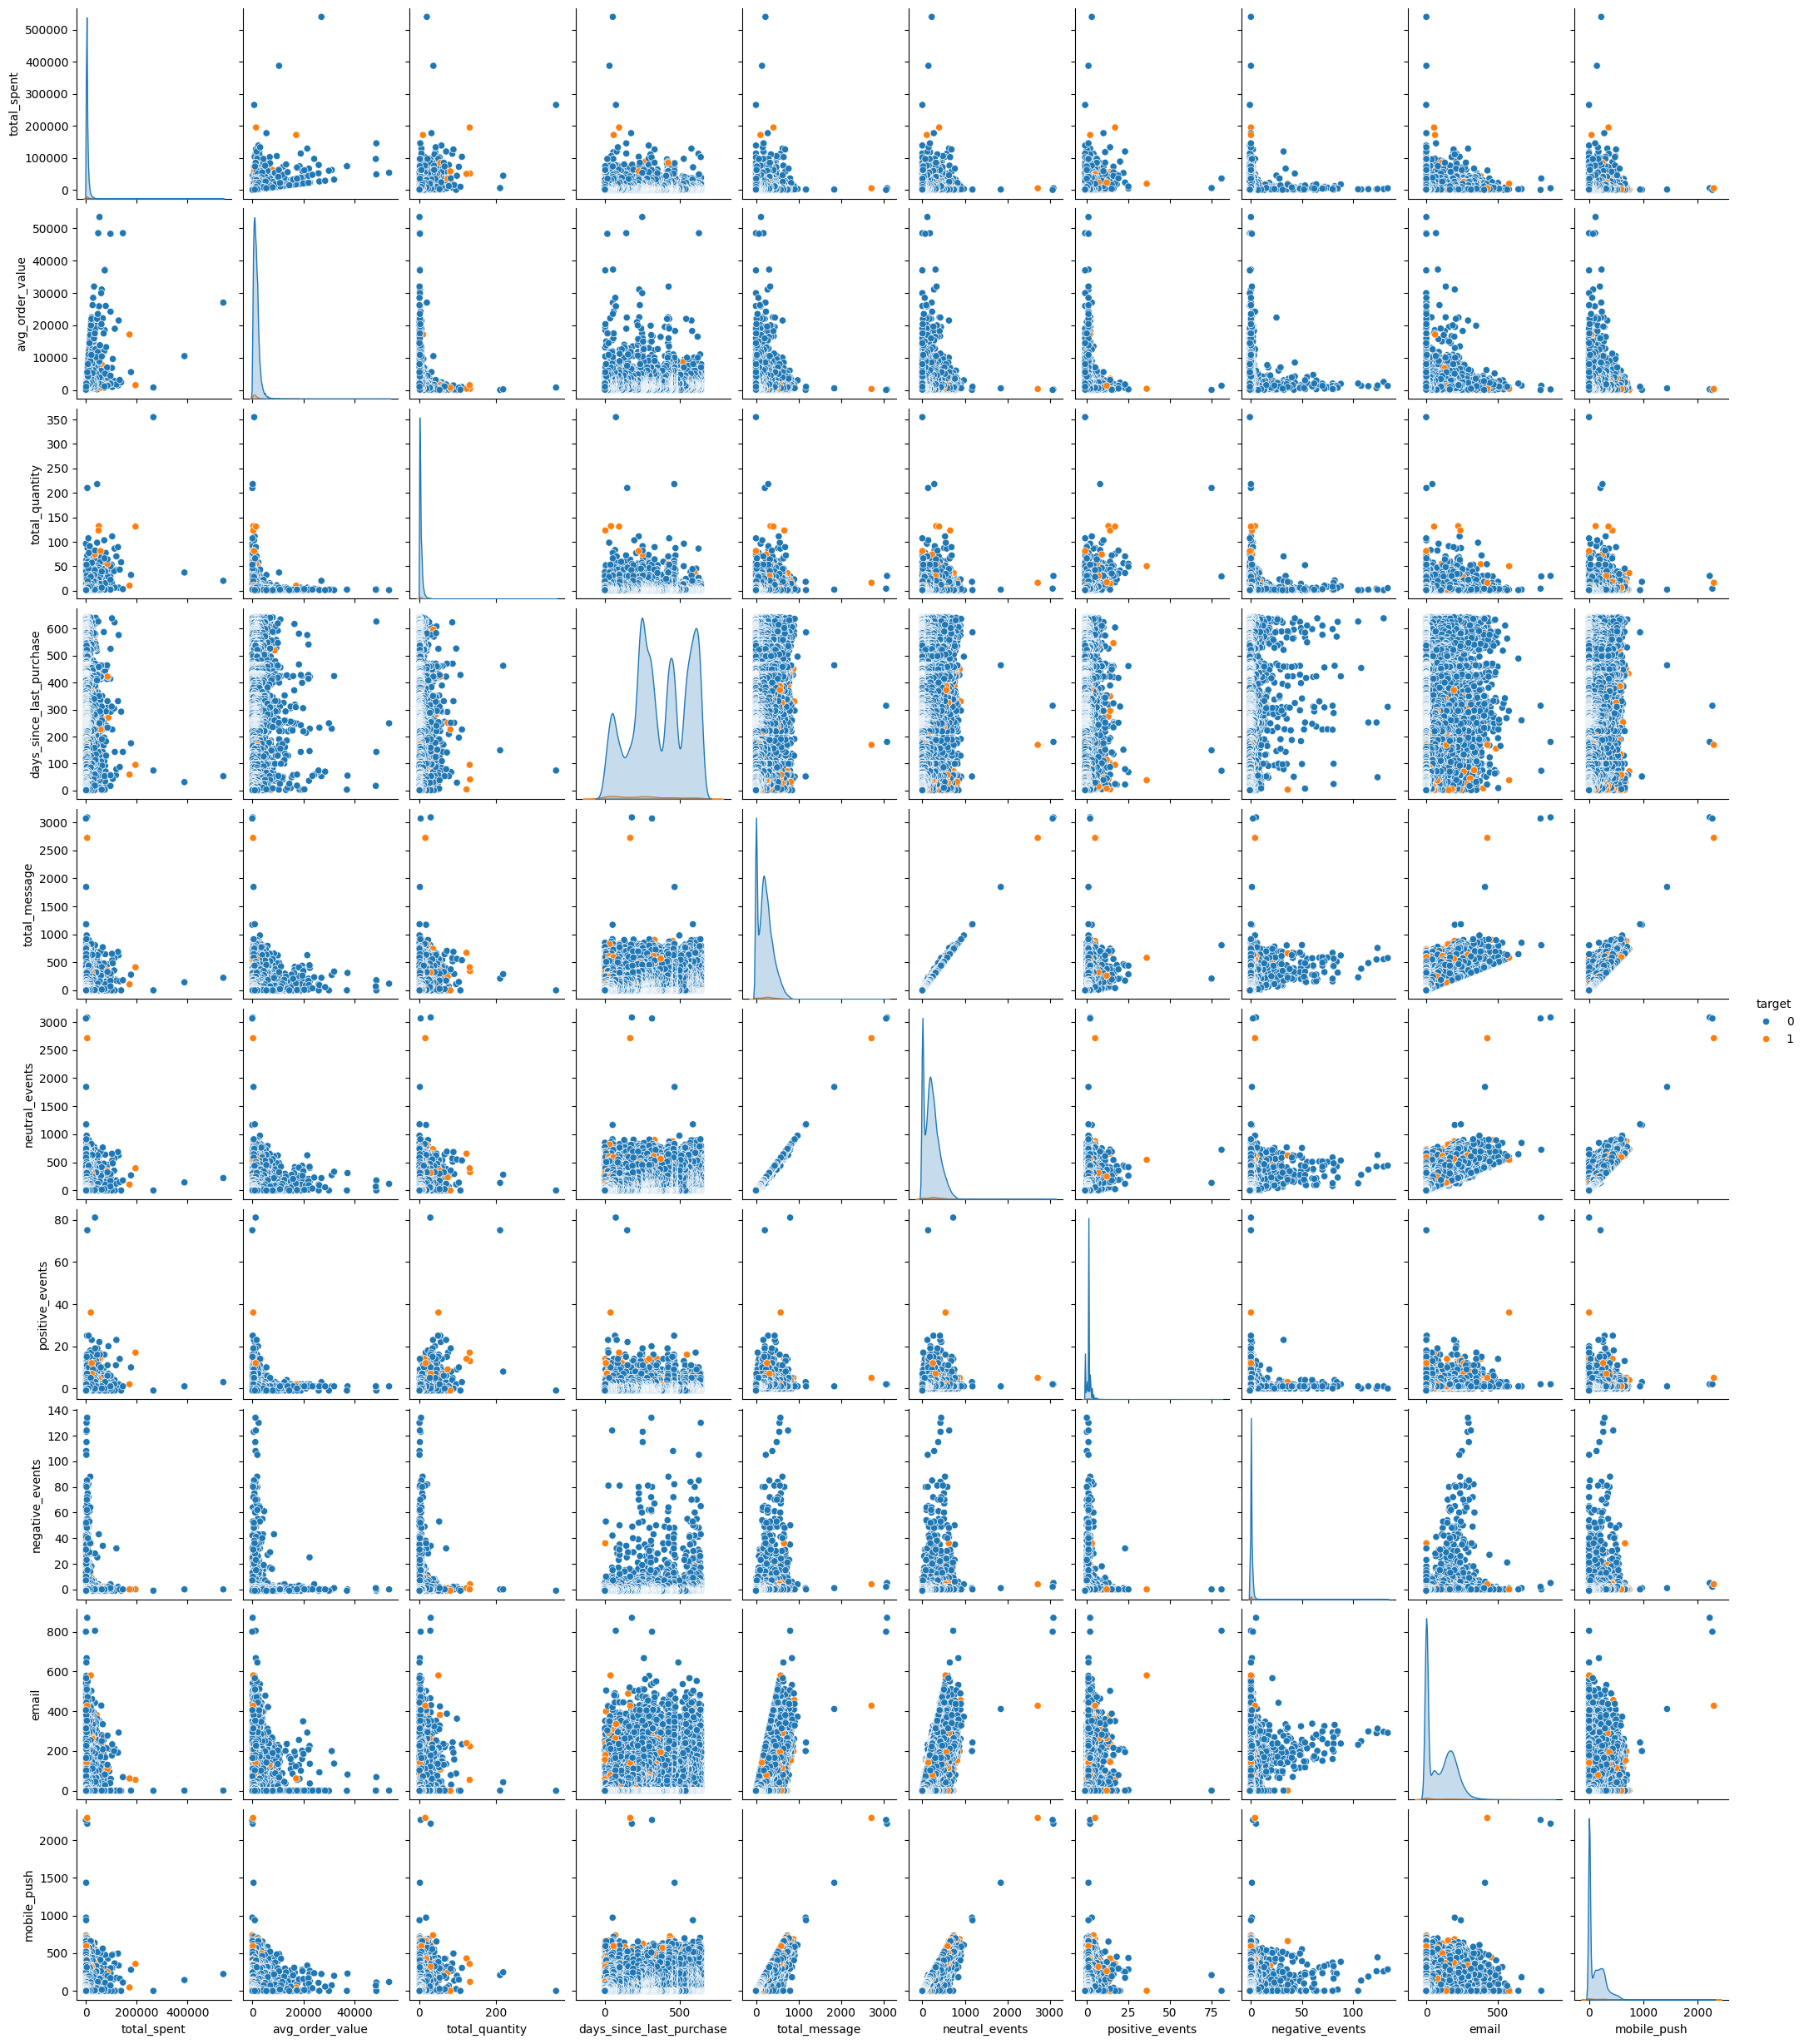

In [58]:
data_purch_event_channel_bez_id = copy.copy(data_purch_event_channel)
data_purch_event_channel_bez_id = data_purch_event_channel.drop('client_id', axis=1)
sns.pairplot(
    data=data_purch_event_channel_bez_id, 
    aspect=.85,
    hue='target');

- признаки не имеют нормальных распределений
- очевидной зависимости не наблюдается
- построим матрицу корреляций
- **Очень важно отметить дисбаланс классов, метка 1 (- клиент совершит покупку в ближайшие 90 дней) на графиках, даже визуально, представлена в очень малом количестве. В основном метка 0 (- клиент не совершит покупку в ближайшие 90 дней). Поэтому очень важно на этапе обучения модели МО провести стратификацию и кроссвалидацию.** 

interval columns not set, guessing: ['target', 'total_spent', 'avg_order_value', 'total_quantity', 'days_since_last_purchase', 'total_message', 'neutral_events', 'positive_events', 'negative_events', 'email', 'mobile_push']


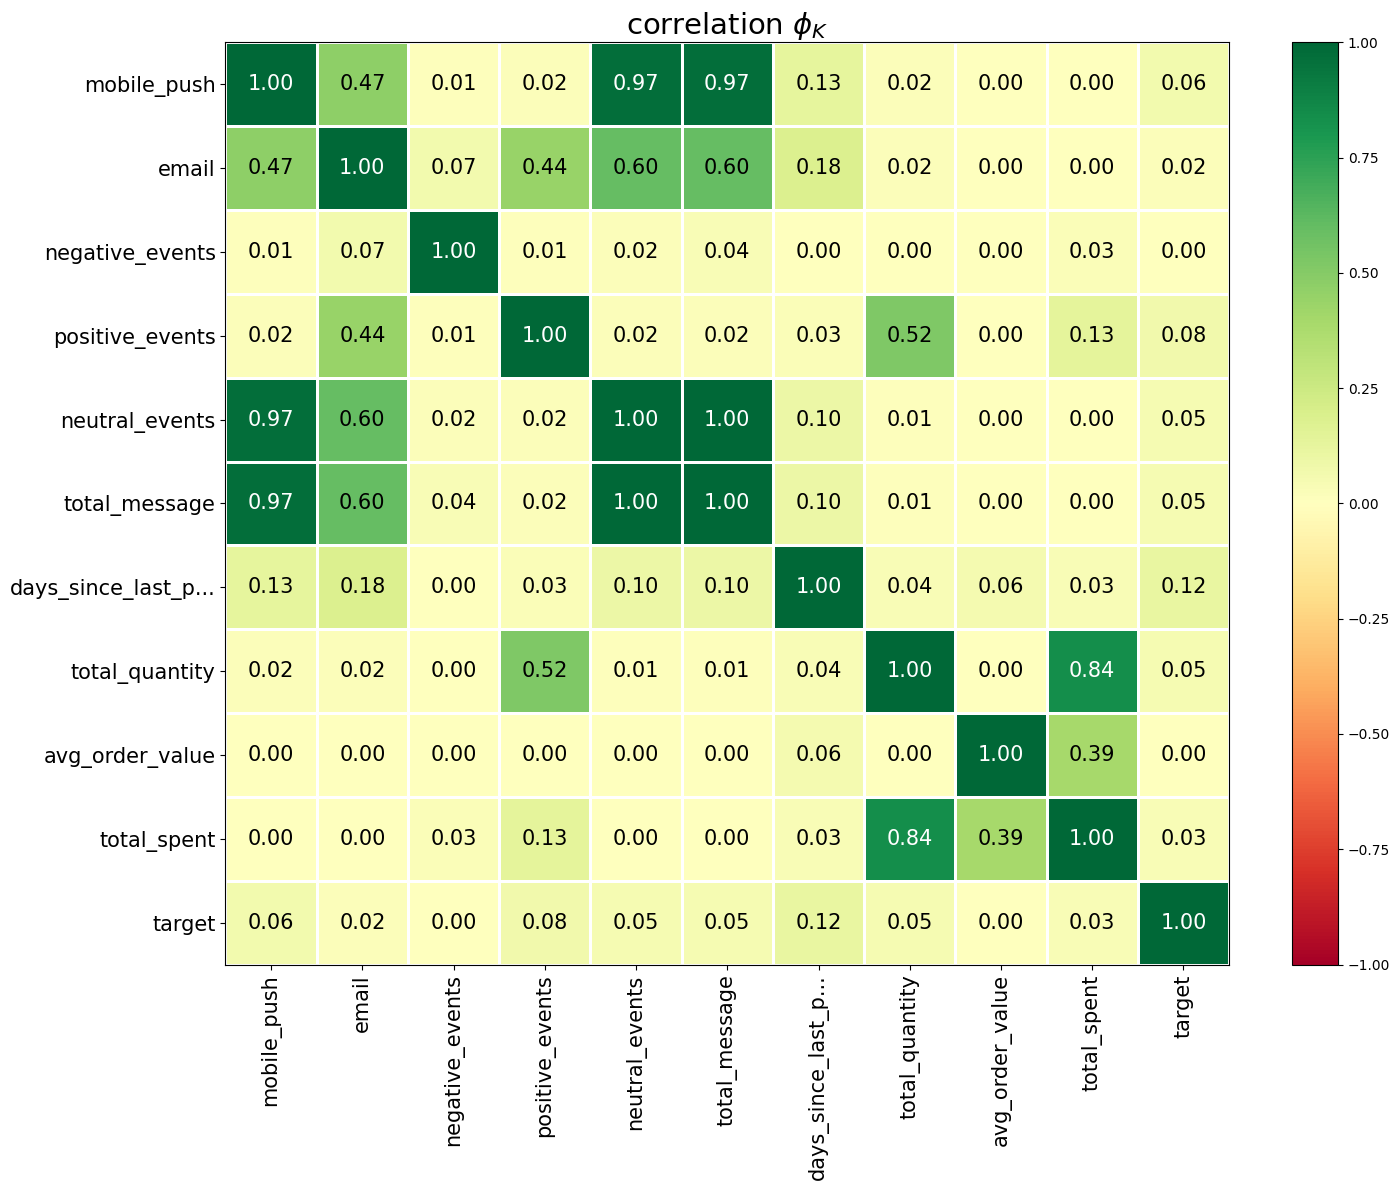

In [59]:
# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = data_purch_event_channel_bez_id.phik_matrix()

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

отмечается сильная корреляция у пар признаков: <br>
- `mobile_push` - `total_message`, коэффициент корреляции - 0,97
- `mobile_push` - `neutral_events`, коэффициент корреляции - 0,97
- `total_message`  - `neutral_events`, коэффициент корреляции - 1
- `total_quantity` - `total_spent`, коэффициент корреляции - 0,84 <br>
Предлагается удалить признаки:<br> 
- `mobile_push`, таким образом мы устраним мультиколленеарность сразу у двух пар,
- `total_message`, таким образом мы устраним мультиколленеарность и исключим из разсмотрения не очевидный признак при анализе важности признаков (количество мобильных пуш уведомлений и общее количество сообщений)
- `total_spent`, так как у нас есть признак  `avg_order_value` и останется признак `total_quantity`, если количество товаров или в среднем потраченные деньги влияют на предсказательную способность,

In [60]:
data_purch_event_channel = data_purch_event_channel.drop('mobile_push', axis=1)
data_purch_event_channel = data_purch_event_channel.drop('total_message', axis=1)
data_purch_event_channel = data_purch_event_channel.drop('total_spent', axis=1)
# проверка
data_purch_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  int64  
 1   target                    49849 non-null  int64  
 2   avg_order_value           49849 non-null  float64
 3   total_quantity            49849 non-null  int64  
 4   days_since_last_purchase  49849 non-null  int64  
 5   neutral_events            49849 non-null  int64  
 6   positive_events           49849 non-null  int64  
 7   negative_events           49849 non-null  int64  
 8   email                     49849 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 3.4 MB


## Выводы по EDA нового датасета 

- признаки не имеют нормальных распределений
- очевидной зависимости не наблюдается
- по матрице корреляций отмечается сильная корреляция у пар признаков: <br>
- `mobile_push` - `total_message`, коэффициент корреляции - 0,97
- `mobile_push` - `neutral_events`, коэффициент корреляции - 0,97
- `total_message`  - `neutral_events`, коэффициент корреляции - 1
- `total_quantity` - `total_spent`, коэффициент корреляции - 0,84 <br>
Предлагается удалить признаки:<br> 
- `mobile_push`, таким образом мы устраним мультиколленеарность сразу у двух пар,
- `total_message`, таким образом мы устраним мультиколленеарность и исключим из разсмотрения не очевидный признак при анализе важности признаков (количество мобильных пуш уведомлений и общее количество сообщений)
- `total_spent`, так как у нас есть признак  `avg_order_value` и останется признак `total_quantity`, если количество товаров или в среднем потраченные деньги влияют на предсказательную способность,

# Создание модели для классификации пользователей

In [61]:
data_purch_event_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   client_id                 49849 non-null  int64  
 1   target                    49849 non-null  int64  
 2   avg_order_value           49849 non-null  float64
 3   total_quantity            49849 non-null  int64  
 4   days_since_last_purchase  49849 non-null  int64  
 5   neutral_events            49849 non-null  int64  
 6   positive_events           49849 non-null  int64  
 7   negative_events           49849 non-null  int64  
 8   email                     49849 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 3.4 MB


In [62]:
# Задаём константы:
RANDOM_STATE = 89
TEST_SIZE = 0.25


X = data_purch_event_channel.drop(['client_id', 'target'], axis=1)
y = data_purch_event_channel['target']

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    # проведем стратификацию
    stratify=y
)


In [63]:
# Создаем пайплайн для сетку параметров для выбора модели МО
pipe = Pipeline([
    ('scaler', StandardScaler()),  # шаг масштабирования по умолчанию
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))  # модель по умолчанию
])

# Сетка параметров для GridSearch
param_grid = [
    {
        'scaler': [StandardScaler(), MinMaxScaler(), None],  # тестируем разные скейлеры
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        # параметры для дерева
        'model__max_depth': [3, 5, 7, None],
        'model__min_samples_split': [2, 5, 10] 
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'model': [KNeighborsClassifier()],
        # параметры для KNN
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
      'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        # параметры для SVC
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    {
        'scaler': [StandardScaler(), MinMaxScaler()],
        'model':  [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        # параметры для логистической регрессии
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.1, 1, 10],
        'model__max_iter': [1000]
    }
]

# Создаём GridSearch
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    cv=5,
    # задайте метрику ROC-AUC
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
# Обучение
grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print('\nЛучший ROC-AUC score на тренировачных данных:', round(grid_search.best_score_, 4))

Fitting 5 folds for each of 76 candidates, totalling 380 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.1, max_iter=1000, penalty='l1',
                                    random_state=89, solver='saga'))])

Лучший ROC-AUC score на тренировачных данных: 0.7045


## Оценим результат модели МО

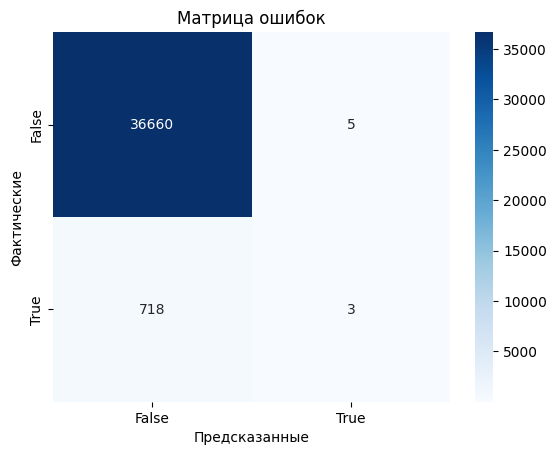

In [64]:
#Предсказания на тренировочных данных
y_train_pred = grid_search.best_estimator_.predict(X_train)
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'])
plt.xlabel('Предсказанные')
plt.ylabel('Фактические')
plt.title('Матрица ошибок')
plt.show()

In [65]:
# выведем метрики
metrics_dict = {
    'accuracy': accuracy_score(y_train, y_train_pred),
    'precision': precision_score(y_train, y_train_pred),
    'recall': recall_score(y_train, y_train_pred)
}

print("\nДополнительные метрики:")
print(metrics_dict)


Дополнительные метрики:
{'accuracy': 0.980661210078639, 'precision': 0.375, 'recall': 0.004160887656033287}


- метрика accuracy - 0,98, то есть модель точно дает прогноз, но в отрыве от других метрик этот показатель не корретно рассматривать. Также ранее отмечали дисбаланс классов по seaborn, а именно небольшой набор меток 1 (клиент совершит покупку в ближайшие 90 дней), матрица ошибок показала нам всего 3 правильных ответа (TP). При большом подавляющем наборе меток 0, модель дает дает 36660 правильных ответов TN.
- Precision тоже не высокий - 0,375, но опять же из за дисбаланса классов, тотал TP + FP  = 8 ответов из которых TP 3, поэтому значение метрики такое. 
- Метрика Recall  - 0.0041 и такая метрика опять же от сильного дисбаланса класса, она как раз таки и показала, что очень многим ответам 0 модель поставила 1. Ее и надо повысить. 

ROC AUC на тренировочных данных: 0.7082


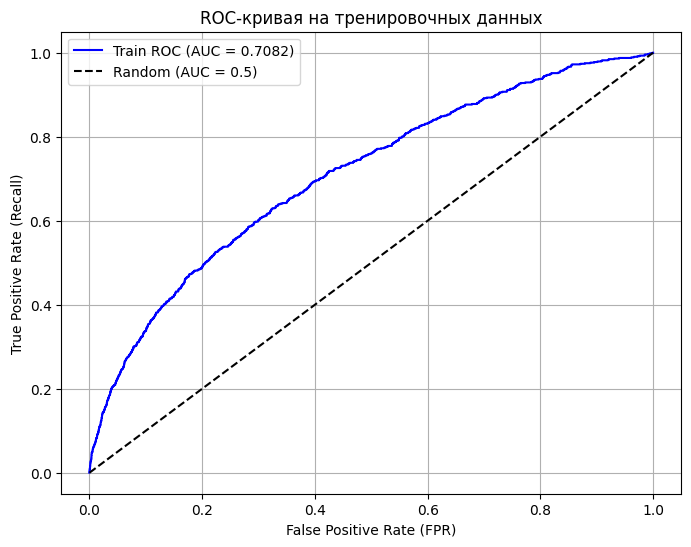

In [66]:
# построим ROC AUC кривую
# Предсказанные вероятности для положительного класса (класс 1)
y_train_proba = grid_search.predict_proba(X_train)[:, 1]

# Рассчитываем AUC-ROC
auc_train = roc_auc_score(y_train, y_train_proba)
print(f"ROC AUC на тренировочных данных: {auc_train:.4f}")

# Рассчитываем FPR, TPR и пороги
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)

# График ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC-кривая на тренировочных данных')
plt.legend()
plt.grid(True)
plt.show()

- кривая ROC AUC закономерно (при показателе 0.7045) выглядит удовлетворительно

Average Precision (AP) на тренировочных данных: 0.0617


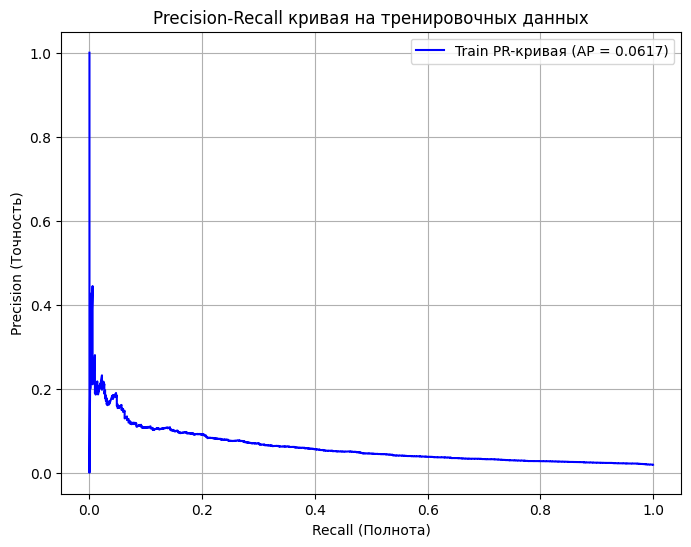

In [67]:
# построим PR кривую

# Рассчитываем Average Precision (AP) — аналог AUC для PR-кривой
ap_train = average_precision_score(y_train, y_train_proba)
print(f"Average Precision (AP) на тренировочных данных: {ap_train:.4f}")

# строим PR кривую
precision_train, recall_train, thresholds_pr = precision_recall_curve(y_train, y_train_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_train, precision_train, label=f'Train PR-кривая (AP = {ap_train:.4f})', color='blue')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Precision-Recall кривая на тренировочных данных')
plt.legend()
plt.grid(True)
plt.show()

- Average Precision (AP) на тренировочных данных: 0.0617 - указывает, что модель хуже случайного угадывания. Кривая PR отражеает метрики представленные ранее.

# Выводы по обучению модели

- Метрика ROC AUC на тренировочных данных показала 0,7045, что соотвествует требуемую значению тех. зададания
Однако:<br>
- метрика accuracy - 0,98, то есть модель точно дает прогноз, но в отрыве от других метрик этот показатель не корретно рассматривать. Также ранее отмечали дисбаланс классов по seaborn, а именно небольшой набор меток 1 (клиент совершит покупку в ближайшие 90 дней), матрица ошибок показала нам всего 3 правильных ответа (TP). При большом подавляющем наборе меток 0, модель дает дает 36660 правильных ответов TN.
- Precision тоже не высокий - 0,375, но опять же из за дисбаланса классов, тотал TP + FP  = 8 ответов из которых TP 3, поэтому значение метрики такое. 
- Метрика Recall  - 0.0041 и такая метрика опять же от сильного дисбаланса класса, она как раз таки и показала, что очень многим ответам 0 модель поставила 1. Ее и надо повысить. 
- кривая ROC AUC закономерно (при показателе 0.7045) выглядит удовлетворительно 
- Average Precision (AP) на тренировочных данных: 0.0617 - указывает, что модель хуже случайного угадывания. Кривая PR отражеает метрики представленные ранее.

# Улучшить модель и максимизировать метрику ROC AUC

Чтобы улучшить модель изменим порог классификации

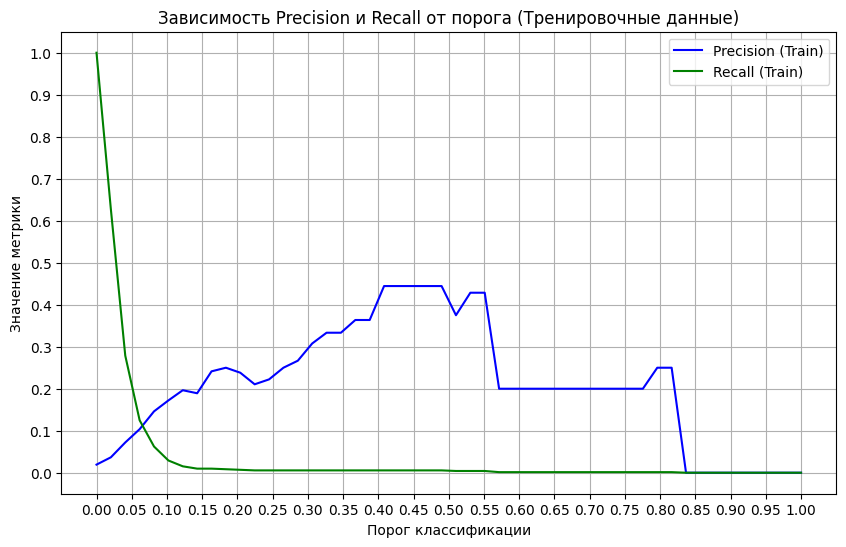

In [68]:
# Задаём диапазон порогов
thresholds = np.linspace(0, 1, 50)
precisions_train = []
recalls_train = []

# Считаем Precision и Recall для каждого порога
for t in thresholds:
    y_train_pred = (y_train_proba >= t).astype(int)
    precisions_train.append(precision_score(y_train, y_train_pred, zero_division=0))  
    recalls_train.append(recall_score(y_train, y_train_pred))

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions_train, label='Precision (Train)', color='blue')
plt.plot(thresholds, recalls_train, label='Recall (Train)', color='green')
# Добавляем частые деления на оси (единственное добавление)
plt.xticks(np.arange(0, 1.05, 0.05))  # Шаг 0.05
plt.yticks(np.arange(0, 1.05, 0.1))   # Шаг 0.1 для оси Y

plt.xlabel('Порог классификации')
plt.ylabel('Значение метрики')
plt.legend()
plt.title('Зависимость Precision и Recall от порога (Тренировочные данные)')
plt.grid(True)
plt.show()

## Величина нового порога классификации и предсказание вероятностей

In [69]:
# Оптимальный порог (возьмём примерное значение)
optimal_threshold = 0.07 

# Предсказания с новым порогом
y_train_pred_optimal = (y_train_proba >= optimal_threshold).astype(int)

## Оценка нового порога классификации

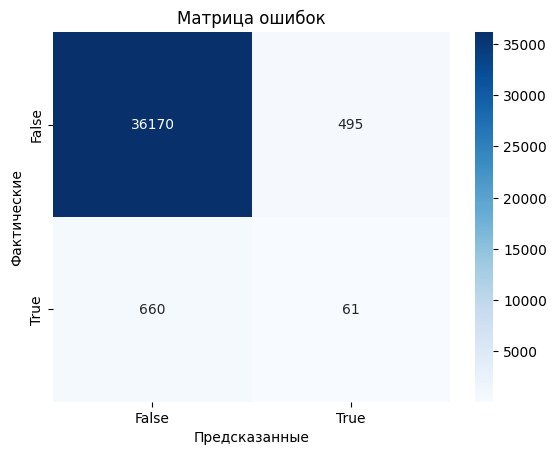

In [70]:
#новая матрица ошибок
cm = confusion_matrix(y_train, y_train_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'])
plt.xlabel('Предсказанные')
plt.ylabel('Фактические')
plt.title('Матрица ошибок')
plt.show()

- матрица ошибок стала лучше с новым порогом классификации

In [71]:
# выведем метрики
metrics_dict_opt = {
    'accuracy': accuracy_score(y_train, y_train_pred_optimal),
    'precision': precision_score(y_train, y_train_pred_optimal),
    'recall': recall_score(y_train, y_train_pred_optimal)
}

print("\nДополнительные метрики:")
print(metrics_dict_opt)


Дополнительные метрики:
{'accuracy': 0.9691060824907719, 'precision': 0.10971223021582734, 'recall': 0.08460471567267684}


- Дополнительные метрики стали немного лучше

## Выводы по улучшению модели МО максимизации метрики ROC AUC

- бы выбран новый порог классификации - 0,07, чтобы увеличить метрику Precision и Recall
- матрица ошибок стала лучше с новым порогом классификации
- Дополнительные метрики стали немного лучше
- Но все же это очень слабые метрики и показатели

# Использование модели градиентного бустига

In [72]:
# Инициализация модели CatBoost 
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=4,
    verbose=100,
    random_state=89
)

# Обучение с валидацией
model.fit(X_train, y_train)

# Предсказание вероятностей
train_proba = model.predict_proba(X_train)[:, 1] 

# ROC-AUC на трейне
train_roc_auc = roc_auc_score(y_train, train_proba)
print(f"ROC-AUC на тренировочных данных: {train_roc_auc:.4f}")


0:	learn: 0.6741043	total: 207ms	remaining: 1m 43s
100:	learn: 0.1216502	total: 1.06s	remaining: 4.18s
200:	learn: 0.0921249	total: 1.8s	remaining: 2.67s
300:	learn: 0.0882907	total: 2.58s	remaining: 1.71s
400:	learn: 0.0871762	total: 3.24s	remaining: 801ms
499:	learn: 0.0865977	total: 4.07s	remaining: 0us
ROC-AUC на тренировочных данных: 0.7358


- модель градиентого бустинга показла ROC AUC 0.73 (сложность модели не высокая)

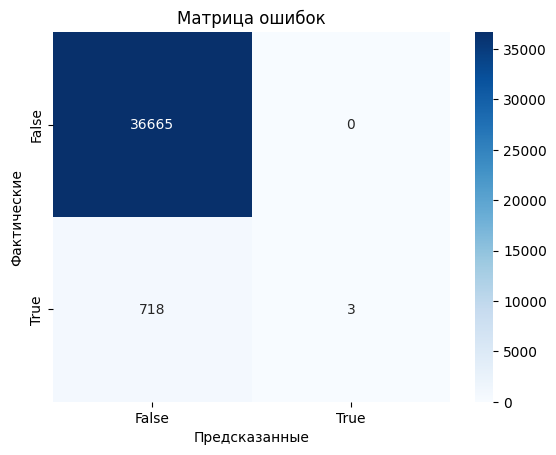

In [73]:
# Получаем  предсказания
y_train_pred = model.predict(X_train)
# матрица ошибок 
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['False', 'True'], 
            yticklabels=['False', 'True'])
plt.xlabel('Предсказанные')
plt.ylabel('Фактические')
plt.title('Матрица ошибок')
plt.show()

## Вывод по модели градиентого бустинга

- результат такой же как и у модели логистической регрессии.

# Вывод по обучению моделей

**Логистическая регерссия с порогом классификации показала ROC AUC 0.7045 и был подобран порог классификации 0,07, чтобы скорректировать метрики accuracy, precision и recall**

# Тестирование модели МО

In [77]:
# Делаем предсказания один раз
y_test_pred = grid_search.best_estimator_.predict(X_test)  
y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]  

# Вычислим метрику roc auc
test_roc_auc = roc_auc_score(y_test, y_test_proba)

# Применяем оптимальный порог (ваш подобранный 0.07)
y_test_pred_optimal = (y_test_proba >= optimal_threshold).astype(int)

# Вычисляем метрики
test_precision = precision_score(y_test, y_test_pred_optimal)
test_recall = recall_score(y_test, y_test_pred_optimal)

# Выводим результаты
print(f"[Тест] ROC-AUC: {test_roc_auc:.4f}")
print(f"[Тест] Precision: {test_precision:.4f}")
print(f"[Тест] Recall: {test_recall:.4f}")

# Матрица ошибок
print("\nМатрица ошибок:")
print(confusion_matrix(y_test, y_test_pred_optimal))

[Тест] ROC-AUC: 0.6985
[Тест] Precision: 0.0895
[Тест] Recall: 0.0708

Матрица ошибок:
[[12050   173]
 [  223    17]]


## Выводы по тестированию модели МО

- Метрика Roc AUC подтвердилась на тестовых данных
- Метрики Precision Recall и матрица ошибок подобны результатам полученных на тренирвочных данных

# Анализ важности признаков

сперва построим график общей значимости признаков, вклад признаков в прогноз модели:

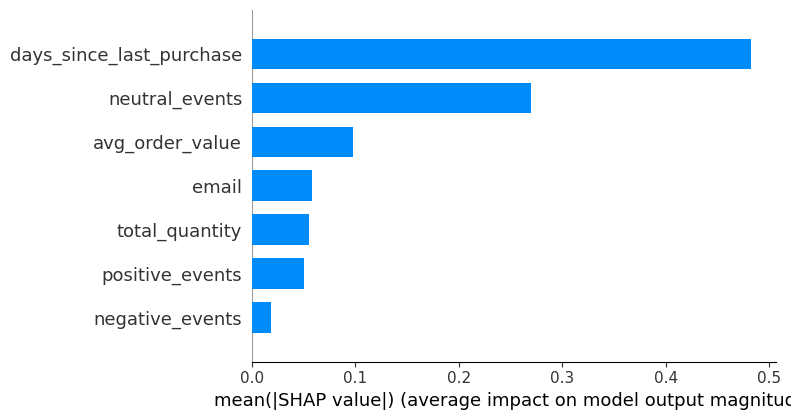

In [75]:
# Извлекаем лучший пайплайн и модель
best_pipeline = grid_search.best_estimator_
best_model = best_pipeline.named_steps['model']

# Получаем масштабированные данные (как в пайплайне)
scaler = best_pipeline.named_steps['scaler']
X_train_scaled = scaler.transform(X_train)

# Создаем объяснитель для логистической регрессии
explainer = shap.LinearExplainer(
    model=best_model,
    masker=X_train_scaled,  # Используем масштабированные данные
    feature_names=X_train.columns  # Сохраняем имена признаков
)

# Вычисляем SHAP-значения
shap_values = explainer(X_train_scaled)

# Визуализация
plt.figure(figsize=(12, 6))
shap.summary_plot(
    shap_values, 
    features=X_train_scaled,
    feature_names=X_train.columns,
    plot_type="bar",
    max_display=17
)


наибольшее влияние оказывает признаки: <br>
- "Дней с последней покупки"
- "Количество нейтральных event-ов"
- "Средний чек заказов" <br>
Признаки в меньшей степени влияют: <br>
- "количество email"
- "количество заказов"
- "количество положительных event-ов"<br>
Признак слабее всех влияет: <br>
- "количество негавтивных event-ов" <br>


построим beeswarm диаграмму Шапли

100%|===================| 37280/37386 [05:25<00:00]        

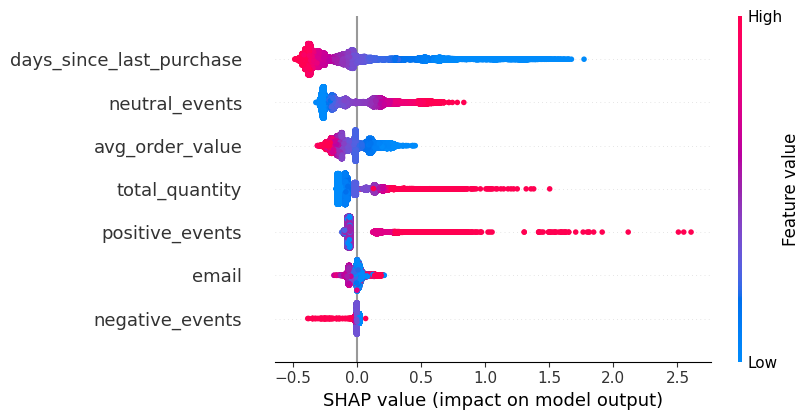

In [76]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

plt.figure(figsize=(20, 6))  # Ширина x Высота
shap.summary_plot(shap_values, X_train, plot_type="dot", max_display=20, show=False)
#plt.tight_layout()  # Чтобы не обрезались подписи
plt.subplots_adjust(left=0.3)
plt.show()

beeswarm диаграмму Шапли показывает:<br>
- чем меньше дней с последней покупки, тем вероятнее клиент совершит покупку в ближайшие 90 дней.
- чем больше нейтральных event-ов, тем вероятнее клиент совершит покупку в ближайшие 90 дней.
- чем меньше средний чек, тем вероятнее клиент совершит покупку в ближайшие 90 дней.
- чем больше количество заказов, тем вероятнее клиент совершит покупку в ближайшие 90 дней.
- чем больше позитивных event-ов, тем вероятнее клиент совершит покупку в ближайшие 90 дней.
- чем меньше негативных event-ов, тем вероятнее клиент совершит покупку в ближайшие 90 дней.
- **Признаки в целом логично отражают покупательское поведение**

# Выводы по проекту

<b><p style="text-align: center;">Выводы по и проекту</p></b>
<b><p style="text-align: center;">Описание целей и задач раздела</p></b>

**Цели проекта в целом достигнута.**

<b><p style="text-align: center;">Цель проекта</p></b>

1. **Предсказать вероятность покупки в течение 90 дней. Достичь метрики ROC AUC 0.7045 - выполнено**<br>
- на тренировачных данных ROC AUC 0.7045 на тестовых данных метрика подтвердилась - 0,6985<br>

Дополнительные задачи выполненные в ходе проекта: <br>

2. **Разработать полезные признаки - выполнено.**  <br>
Разработаны следудующие признаки:<br>
- *общая потраченная сумма клиентом*
- *средний чек заказов*
- *суммарное количество покупок клиентом*
- *кол во дней с последней покупки*
- *количество полученных сообщений по клиентам*
- *3 признака: количество ивентов соверешенных клиентом, где ивенты условно поделены на "нейтральные" ('open', 'click', 'close', 'send'), ед., "позитивные" ('purchase', 'subscribe'),ед., негативные" ('unsubscribe', 'hbq_spam',  'hard_bounce', 'soft_bounce', 'complain'), ед.*
-  *количество взаимодействий клиента с каналом (total messages)*
-  *2 пизнака  - количество взаимодействий клиента с по способу комуникации по email по mobile push*

отмечается мультиколленеарность по некоторым парам, поэтому были удалены следующие признаки, для устранения мультиколленеарность:<br>
- общая потраченная сумма клиентом
- количество взаимодействий клиента по 'mobile_push'
- количество взаимодействий клиента с каналом (total messages)<br>


3. **Создать модель для классификации пользователей - выполнено.** <br>
- были протестированые разные модели "простые" модели и модель градиентного бустинга, лучшая модель из "простых" - логистическая регрессия показала метрику 0,7045, градиентый бустик с минимальным набором гиперпараметров 0,73. однако все модели показали не удовлетворительные дополнительные метрики (accuracy, precision recall) в условиях примерно одинаковых метрик ROC AUC  и не удовлетворительных остальных выбор сделан в пользу "простой" модели - логистической регрессии.<br>

4. **Улучшить модель и максимизировать метрику roc_auc - выполнено.**<br>
- Выбран порог классификации - 0,07, который незначительно но улучшает метрики precision и recall <br>

5. **Выполнено тестирование** <br>
- метрика ROC AUC подтвердила обучение модели МО - 0,6985  <br>


<b><p style="text-align: center;">Проблемы и трудности</p></b>
- главная проблема проекта очень сильный дисбаланс классов, что сильно влияет на матрицу ошибок.<br>

<b><p style="text-align: center;">Рекомендации по дальнейшим шагам и развитию проекта.</p></b>
- устранить дисбаланс классов, семплировать данные, очистить от шума
- альтернативой может быть стоит усложнить модель градиентного бустинга, увелисить кол-во гипер параметров с целью увеличить метрику ROC AUC и остальные.
- добавление новых признаков в услвоиях очень сильного дисбаланса классов не видется верным шагом в рамках этого проекта.<br> 

<b><p style="text-align: center;">Рекомендации для бизнеса </p></b>
Соогласно полученным результатам при обучении модели МО и анализе важности признаков, можно сделать следующие основные выводы:<br>
наибольшее влияние оказывает признаки: <br>
- "Дней с последней покупки"
- "Количество нейтральных event-ов"
- "Средний чек заказов" <br>
Признаки в меньшей степени влияют: <br>
- "количество email"
- "количество заказов"
- "количество положительных event-ов"<br>
Признак слабее всех влияет: <br>
- "количество негавтивных event-ов" <br>
В соотвествии с полченным результатами разработать программу маркетинга.<br>

**Признаки в целом логично отражают покупательское поведение**<br>
- чем меньше дней с последней покупки, тем вероятнее клиент совершит покупку 
- чем больше нейтральных event-ов, тем вероятнее клиент совершит покупку 
- чем меньше средний чек, тем вероятнее клиент совершит покупку 
- чем больше количество заказов, тем вероятнее клиент совершит покупку 
- чем больше позитивных event-ов, тем вероятнее клиент совершит покупку 
- чем меньше негативных event-ов, тем вероятнее клиент совершит покупку 
